# Environment

In [1]:
library(msigdbr)
library(dplyr)
library(tibble)
library(purrr)
library(stringr)
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
library(ggplot2)


library(Seurat)
library(patchwork)
library(tidyverse) 

set.seed(1234)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




clusterProfiler v4.12.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

S Xu, E Hu, Y Cai, Z Xie, X Luo, L Zhan, W Tang, Q Wang, B Liu, R Wang,
W Xie, T Wu, L Xie, G Yu. Using clusterProfiler to characterize
multiomics data. Nature Protocols. 2024, doi:10.1038/s41596-024-01020-z


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

 

In [2]:
BiocManager::install("org.Mm.eg.db")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.19 (BiocManager 1.30.26), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'org.Mm.eg.db'”
Old packages: 'ade4', 'ape', 'aplot', 'AUCell', 'Banksy', 'bedr',
  'BiocFileCache', 'BiocManager', 'bmp', 'bookdown', 'broom', 'bslib', 'Cairo',
  'caret', 'ccTensor', 'CelliD', 'checkmate', 'cicero', 'circlize', 'circular',
  'ClassDiscovery', 'clock', 'ClusterR', 'colorspace', 'concaveman', 'cowplot',
  'credentials', 'crosstalk', 'crul', 'cubature', 'curl', 'data.tree',
  'dbplyr', 'dbscan', 'dendextend', 'DescTools', 'devtools', 'dials',
  'DiceKriging', 'digest', 'doBy', 'doFuture', 'downlit', 'DT', 'dtplyr',
  'dynutils', 'emmeans', 'evaluate', 'extrafont', 'extrafontdb', 'Fa

In [3]:
install.packages("ontologyIndex")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# GO analysis
reference code: 
https://www.melbournebioinformatics.org.au/tutorials/tutorials/seurat-go/seurat-go/

In [4]:
library(org.Mm.eg.db)
library(ontologyIndex)

In [5]:
# Read GO file
go <- get_ontology("../../data/go/go.obo")
descendant_terms <- get_descendants(get_ontology("../../data/go/go.obo"), roots="GO:0002376")

# MDSC data

In [6]:
MDSC <- readRDS("../../results/sc_rna/06_02_myeloid/intermediate/01_clustering/mono.rds")
MDSC

An object of class Seurat 
16245 features across 3695 samples within 1 assay 
Active assay: RNA (16245 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 3 dimensional reductions calculated: pca, umap, tsne

In [7]:
mdsc_markers <- FindAllMarkers(
  MDSC,
  only.pos = TRUE,
  min.pct = 0.25,
  logfc.threshold = 0.25
)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



# Filter gene

In [8]:
gene_list <- Features(MDSC)
gene_name <- data.frame(gene_list)

# Find marker genes for each cluster

In [9]:
Cluster0.markers <- mdsc_markers[mdsc_markers$cluster==0 & mdsc_markers$p_val_adj < 0.05, ]
Cluster1.markers <- mdsc_markers[mdsc_markers$cluster==1 & mdsc_markers$p_val_adj < 0.05, ]
Cluster2.markers <- mdsc_markers[mdsc_markers$cluster==2 & mdsc_markers$p_val_adj < 0.05, ]
Cluster3.markers <- mdsc_markers[mdsc_markers$cluster==3 & mdsc_markers$p_val_adj < 0.05, ]

Cluster0_filter.markers <- mdsc_markers[mdsc_markers$cluster==0 & mdsc_markers$p_val_adj < 0.05, ]
Cluster1_filter.markers <- mdsc_markers[mdsc_markers$cluster==1 & mdsc_markers$p_val_adj < 0.05, ]
Cluster2_filter.markers <- mdsc_markers[mdsc_markers$cluster==2 & mdsc_markers$p_val_adj < 0.05, ]
Cluster3_filter.markers <- mdsc_markers[mdsc_markers$cluster==3 & mdsc_markers$p_val_adj < 0.05, ]

# convert gene list
convert_gene0 <- gene_name %>% filter(!(gene_list %in% Cluster0.markers$gene)) 
convert_gene1 <- gene_name %>% filter(!(gene_list %in% Cluster1.markers$gene)) 
convert_gene2 <- gene_name %>% filter(!(gene_list %in% Cluster2.markers$gene)) 
convert_gene3 <- gene_name %>% filter(!(gene_list %in% Cluster3.markers$gene)) 

# Convert gene symbols to Enterz IDs

In [10]:
Cluster0_filter.gene_ids <- bitr(Cluster0_filter.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster1_filter.gene_ids <- bitr(Cluster1_filter.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster2_filter.gene_ids <- bitr(Cluster2_filter.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)
Cluster3_filter.gene_ids <- bitr(Cluster3_filter.markers$gene, fromType = "SYMBOL",
                                   toType = "ENTREZID", OrgDb = org.Mm.eg.db)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster0_filter.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“2.43% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster1_filter.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“2.55% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster2_filter.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“4.07% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(Cluster3_filter.markers$gene, fromType = "SYMBOL", toType = "ENTREZID", :
“2% of input gene IDs are fail to map...”


In [11]:
out_dir     <- "../../results/sc_rna/06_04_GO/"
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)
write.csv(Cluster0_filter.gene_ids, file = file.path(out_dir, "Cluster0_gene_ids.csv"))
write.csv(Cluster1_filter.gene_ids, file = file.path(out_dir, "Cluster1_gene_ids.csv"))

# Cluster 0

In [12]:
Cluster0_filter.ego <- enrichGO(gene = Cluster0_filter.gene_ids$ENTREZID, 
                        OrgDb = org.Mm.eg.db, 
                        ont = "BP", # biological process
                        pAdjustMethod = "BH", 
                        pvalueCutoff = 0.05, 
                        qvalueCutoff = 0.05, 
                        readable = TRUE)

In [13]:
Cluster0_filter.ego@result <- Cluster0_filter.ego@result[Cluster0_filter.ego@result$ID %in% descendant_terms,]

In [14]:
Cluster0_filter.ego.simplify <- simplify(Cluster0_filter.ego)

# Cluster 1

In [15]:
Cluster1_filter.ego <- enrichGO(gene = Cluster1_filter.gene_ids$ENTREZID, 
                        OrgDb = org.Mm.eg.db, 
                        ont = "BP", # biological process
                        pAdjustMethod = "BH", 
                        pvalueCutoff = 0.05, 
                        qvalueCutoff = 0.05, 
                        readable = TRUE)

In [16]:
Cluster1_filter.ego@result <- Cluster1_filter.ego@result[Cluster1_filter.ego@result$ID %in% descendant_terms,]

In [17]:
Cluster1_filter.ego.simplify <- simplify(Cluster1_filter.ego)

# Cluster 0 and 1

In [18]:
p0dot<-dotplot(Cluster0_filter.ego.simplify, showCategory=10, title="Enriched in Cluster 0")
p1dot<-dotplot(Cluster1_filter.ego.simplify, showCategory=10, title="Enriched in Cluster 1")

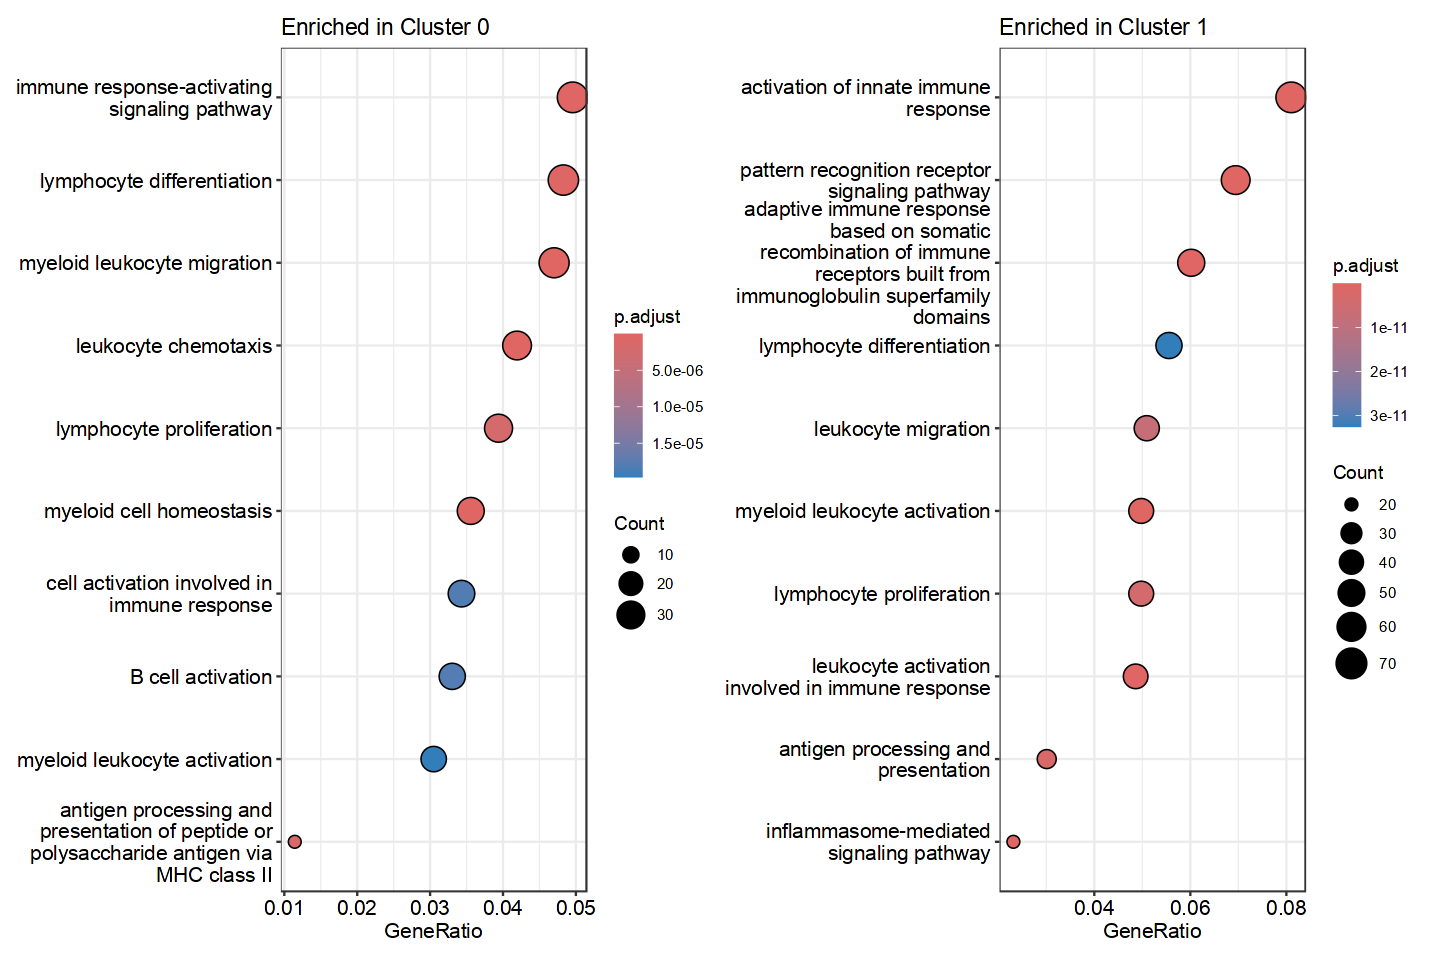

In [19]:
options(repr.plot.width = 12, repr.plot.height = 8)
p0dot+p1dot

In [20]:
p0bar<-barplot(Cluster0_filter.ego.simplify, showCategory=10, title="Enriched in Cluster 0")
p1bar<-barplot(Cluster1_filter.ego.simplify, showCategory=10, title="Enriched in Cluster 1")

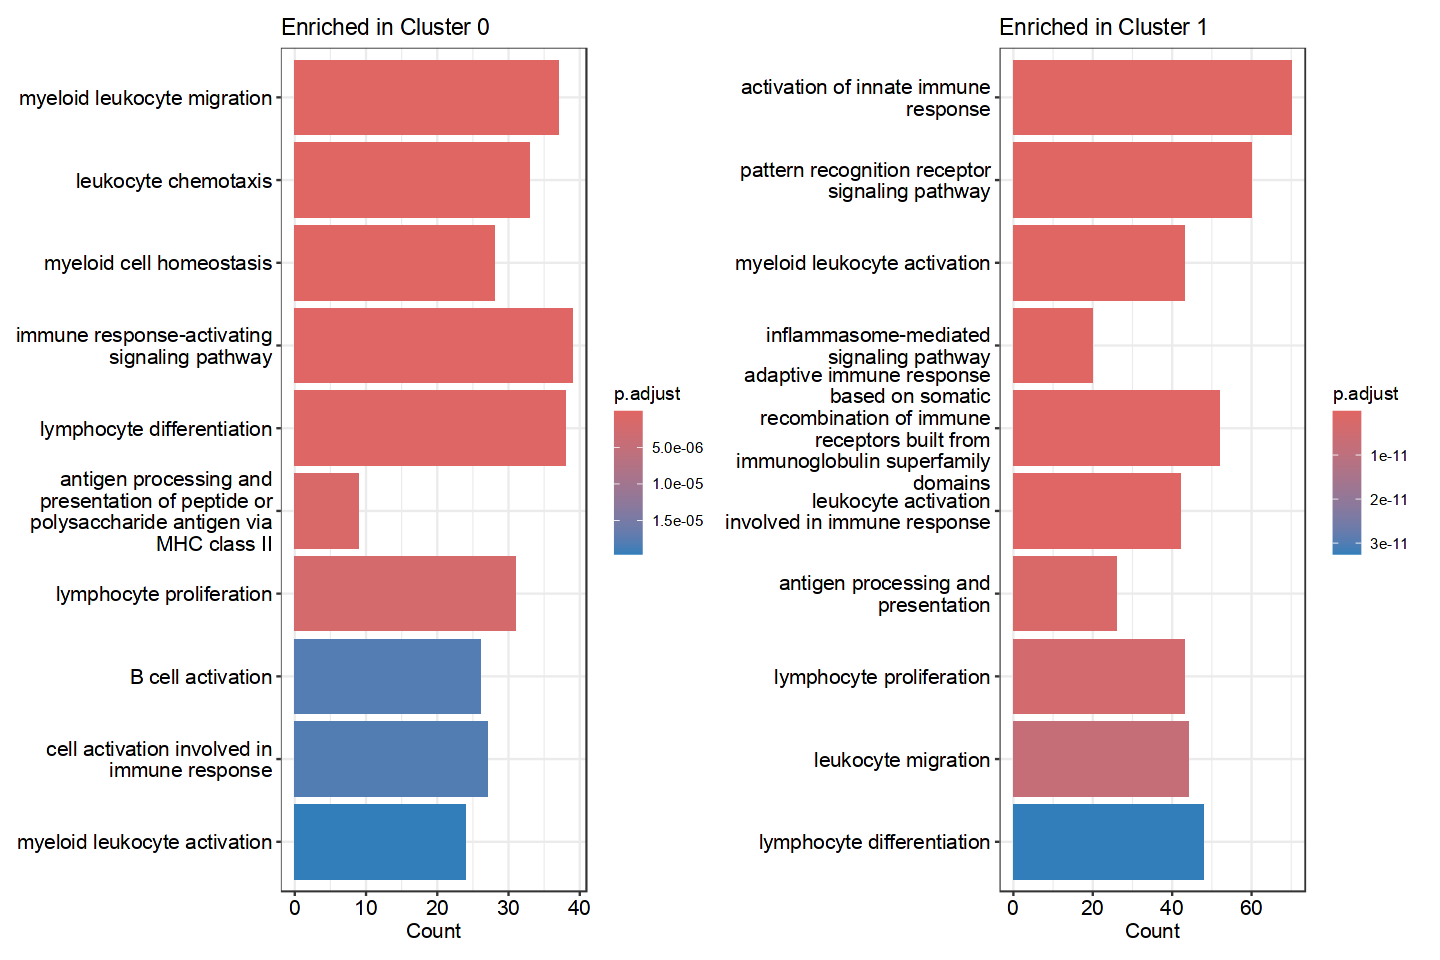

In [21]:
options(repr.plot.width = 12, repr.plot.height = 8)
p0bar+p1bar

In [22]:
ggsave(file = file.path(out_dir, "cluster0_barplot_highdpi.jpeg"), plot = p0bar, width = 6, height = 8, dpi = 1200)
ggsave(file = file.path(out_dir, "cluster1_barplot_highdpi.jpeg"), plot = p1bar, width = 6, height = 8, dpi = 1200)

ggsave(file = file.path(out_dir, "cluster0_barplot_highdpi.pdf"), plot = p0dot, width = 6, height = 8, dpi = 1200)
ggsave(file = file.path(out_dir, "cluster1_barplot_highdpi.pdf"), plot = p1dot, width = 6, height = 8, dpi = 1200)